In [112]:
import torch
from sbi.inference import MNPE
from sbi.utils import BoxUniform
import pandas as pd
import numpy as np
import pathlib 


from sklearn.neighbors import NearestNeighbors


import os
import json
import hashlib
from pathlib import Path
from datetime import datetime
from typing import Optional


import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [113]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from sklearn.neighbors import NearestNeighbors




def compute_centered_track_asymmetry(x, eps=1e-12):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return 0.0
    center = np.mean(x)
    n_left = np.sum(x < center)
    n_right = np.sum(x > center)
    total = n_left + n_right
    if total == 0:
        return 0.0
    return (n_right - n_left) / (total + eps)

def compute_centered_nn_asymmetry(x, z, eps=1e-12):
    x = np.asarray(x, float)
    z = np.asarray(z, float)
    if x.size < 2:
        return 0.0
    center = np.mean(x)
    left_mask = x < center
    right_mask = x > center
    left_pts = np.column_stack((x[left_mask], z[left_mask]))
    right_pts = np.column_stack((x[right_mask], z[right_mask]))
    def mean_nn(points):
        if points.shape[0] < 2:
            return np.nan
        nn = NearestNeighbors(n_neighbors=2).fit(points)
        dists, _ = nn.kneighbors(points)
        return float(np.mean(dists[:, 1]))
    d_left = mean_nn(left_pts)
    d_right = mean_nn(right_pts)
    if np.isnan(d_left) or np.isnan(d_right):
        return 0.0
    return (d_right - d_left) / (d_right + d_left + eps)

# The rest of your code (relative_bin_fractions_from_events, infer_relative_bin_edges) remains unchanged.
# The rest of your code (relative_bin_fractions_from_events, infer_relative_bin_edges) remains unchanged.
def preprocess2(data_path: str | Path, n_bins: int = 6):
    df = pd.read_csv(data_path)
    rename_map = {"x_ang": "x", "y_ang": "y", "z_ang": "z"}
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    required_cols = ["x", "y", "z", "ion_number", "parity"]
    for c in required_cols:
        if c not in df.columns:
            raise KeyError(f"Missing required column '{c}' in {data_path}")

    # Handle energy columns
    if "energy_keV" in df.columns:
        energy_keV = pd.to_numeric(df["energy_keV"], errors="coerce")
    elif "energy_eV" in df.columns:
        energy_keV = pd.to_numeric(df["energy_eV"], errors="coerce") / 1e3
    elif "energy" in df.columns:
        e_raw = pd.to_numeric(df["energy"], errors="coerce")
        energy_keV = e_raw / 1e3 if np.nanmax(e_raw) > 3000 else e_raw
    else:
        raise KeyError("No energy column found.")

    # Ensure numeric types
    df["x"] = pd.to_numeric(df["x"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    df["z"] = pd.to_numeric(df["z"], errors="coerce")
    df["ion_number"] = pd.to_numeric(df["ion_number"], errors="coerce")
    df["energy_keV"] = pd.to_numeric(energy_keV, errors="coerce")
    df["parity"] = pd.to_numeric(df["parity"], errors="coerce")

    df = df.dropna(subset=["x", "y", "z", "ion_number", "energy_keV", "parity"])
    df = df.reset_index(drop=True)

    print(f"[DEBUG] Unique parity values in raw data: {sorted(df['parity'].unique())}")

    bin_edges = infer_relative_bin_edges(n_bins=n_bins)
    rows, x_obs_list, theta_list, track_ids = [], [], [], []

    df["energy_int"] = df["energy_keV"].round().astype(int)

    for (E_int, ion_no, par), g in df.groupby(["energy_int", "ion_number", "parity"], sort=False):
        x = g["x"].values.astype(float)
        z = g["z"].values.astype(float)
        if x.size == 0:
            continue

        # === ENERGY FEATURES (magnitudes) ===
        mean_depth = float(np.mean(np.abs(x)))        # extent of displacement
        max_depth = float(np.max(np.abs(x)))          # furthest excursion
        norm_depth = float(np.percentile(np.abs(x), 95))
        n_vac = int(x.size)
        rbin_fracs = relative_bin_fractions_from_events(np.abs(x), norm_depth, bin_edges)

        # === PARITY-SENSITIVE FEATURES (signed) ===
        frac_pos = float(np.mean(x > 0))
        frac_neg = 1.0 - frac_pos
        mean_x_signed = float(np.mean(x))
        x_std = x.std() + 1e-12
        skew_x = float(np.mean((x - x.mean())**3) / (x_std**3))
        signed_com = float(np.sum(np.sign(x) * np.abs(x)) / (np.sum(np.abs(x)) + 1e-12))
        corr_xz = float(np.corrcoef(x, z)[0, 1]) if x.size > 1 else 0.0

        # === ASYMMETRY FEATURES (around global zero, not local mean) ===
        asym_count = compute_centered_track_asymmetry(x)     # uses global zero
        asym_nn = compute_centered_nn_asymmetry(x, z)

        # === BUILD SUMMARY ROW ===
        tid = f"E{E_int}_ion{int(ion_no)}_p{int(par)}"
        rows.append({
            "track_id": tid,
            "energy_keV": float(E_int),
            "parity": int(par),

            # Energy features
            "mean_depth_A": mean_depth,
            "max_depth_A": max_depth,
            "vacancies_per_ion": n_vac,
            **{f"rbin_frac_{i+1}": rbin_fracs[i] for i in range(n_bins)},

            # Parity-sensitive
            "frac_pos": frac_pos,
            "mean_x_signed": mean_x_signed,
            "skew_x": skew_x,
            "signed_com": signed_com,
            "corr_xz": corr_xz,

            # Asymmetry features
            "asym_count_centered": asym_count,
            "asym_nn_centered": asym_nn,
        })

        # === COMBINE FEATURE VECTOR ===
        x_obs_list.append([
            mean_depth, max_depth, n_vac,
            *rbin_fracs,
            frac_pos, mean_x_signed, skew_x, signed_com, corr_xz,
            asym_count, asym_nn
        ])

        # === PARAMETER VECTOR (energy, parity→0/1) ===
        par_index = int(0 if par == -1 else 1)
        theta_list.append([float(E_int), float(par_index)])
        track_ids.append(tid)

    # Convert to tensors
    df_summary = pd.DataFrame(rows)
    x_obs = torch.tensor(np.array(x_obs_list, dtype=np.float32))
    theta = torch.tensor(np.array(theta_list, dtype=np.float32))

    # ✅ Fix parity encoding explicitly (redundant safety)
    theta[:, 1] = (theta[:, 1] == 1).float()

    print(f"[DEBUG] Number of tracks created: {len(track_ids)}")
    print(f"[DEBUG] x_obs shape: {x_obs.shape}")
    print(f"[DEBUG] theta shape: {theta.shape}")
    print(f"[DEBUG] Unique energies (keV): {sorted(np.unique(theta[:, 0]))}")
    print(f"[DEBUG] Unique parities: {sorted(np.unique(theta[:, 1]))}")
    print(f"[DEBUG] Energy range: [{theta[:, 0].min():.1f}, {theta[:, 0].max():.1f}] keV")
    print(f"[DEBUG] First 10 theta samples (energy, parity):\n{theta[:10]}")

    if len(track_ids) < 50:
        print(f"[WARNING] Only {len(track_ids)} tracks found. MNPE needs at least 100-500 for good training.")

    parity_vals = set(theta[:, 1].tolist())
    if not parity_vals.issubset({0.0, 1.0}):
        print(f"[WARNING] Parity contains unexpected values: {parity_vals}. Should be {{0.0, 1.0}}")

    return x_obs, theta, track_ids, {"rel_bin_edges": bin_edges}, df_summary

In [114]:
x_obs, theta, track_ids, meta, df_summary = preprocess2(
    Path("/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies_with_parity_centered.csv"), n_bins=6
)
# ---------------------------------------------------------
# === Normalization (apply right after preprocess2) ===
# ---------------------------------------------------------

x_mean = x_obs.mean(0, keepdim=True)
x_std = x_obs.std(0, keepdim=True) + 1e-8
x_obs_norm = (x_obs - x_mean) / x_std

[DEBUG] Unique parity values in raw data: [-1, 1]
[DEBUG] Number of tracks created: 9200
[DEBUG] x_obs shape: torch.Size([9200, 16])
[DEBUG] theta shape: torch.Size([9200, 2])
[DEBUG] Unique energies (keV): [1.0, 2.0, 5.0, 8.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]
[DEBUG] Unique parities: [0.0, 1.0]
[DEBUG] Energy range: [1.0, 100.0] keV
[DEBUG] First 10 theta samples (energy, parity):
tensor([[ 1.,  1.],
        [ 2.,  1.],
        [ 5.,  1.],
        [ 8.,  1.],
        [10.,  1.],
        [15.,  1.],
        [20.,  1.],
        [25.,  1.],
        [30.,  1.],
        [35.,  1.]])


In [115]:
feature_cols = [
    # Energy features
    "mean_depth_A", "max_depth_A", "vacancies_per_ion",
    "rbin_frac_1", "rbin_frac_2", "rbin_frac_3",
    "rbin_frac_4", "rbin_frac_5", "rbin_frac_6",

    # Parity-sensitive features
    "frac_pos", "mean_x_signed", "skew_x",
    "signed_com", "corr_xz",

    # Asymmetries
    "asym_count_centered", "asym_nn_centered"
]

In [116]:
from sbi.inference import NPE
from sbi.utils import BoxUniform

# --- Prior (energy + parity) ---
prior = BoxUniform(low=torch.tensor([1.0, 0.0]), high=torch.tensor([100.0, 1.0]))

# --- Build inference engine ---
inference = NPE(prior=prior, density_estimator="nsf")

# --- Train posterior network ---
posterior_net = inference.append_simulations(theta, x_obs_norm).train()
# --- Build posterior object for sampling ---
posterior = inference.build_posterior(posterior_net)

 Neural network successfully converged after 91 epochs.

In [117]:
def make_x_test_mnle(df_summary, n_per_energy=1, random_state=42):
    """
    Pick representative tracks per (energy, parity) group for MNLE testing.
    Returns both the subset DataFrame and the feature tensor x_test_torch.
    """
    import pandas as pd, torch

    df_summary = df_summary.copy()
    df_summary["energy_int"] = df_summary["energy_keV"].round().astype(int)

    group_cols = ["energy_int"]
    if "parity" in df_summary.columns:
        group_cols.append("parity")

    sampled_rows = []
    for _, group in df_summary.groupby(group_cols):
        n = min(n_per_energy, len(group))
        sampled_rows.append(group.sample(n=n, random_state=random_state))

    x_test = pd.concat(sampled_rows).reset_index(drop=True)

    print(f"[INFO] Picked {len(x_test)} tracks across {x_test['energy_int'].nunique()} energies.")
    if "parity" in x_test.columns:
        print(x_test["parity"].value_counts())

    # build feature tensor
    feature_cols = [c for c in df_summary.columns
                    if c not in ("track_id","energy_keV","energy_int")]
    x_test_tensor = torch.tensor(x_test[feature_cols].values, dtype=torch.float32)

    return x_test, x_test_tensor

In [118]:
import pandas as pd
import torch

def sample_test_tracks(df_summary, n_per_energy=1, random_state=42):
    """Pick a few representative tracks (both parities if available)."""
    df_summary = df_summary.copy()
    df_summary["energy_int"] = df_summary["energy_keV"].round().astype(int)

    group_cols = ["energy_int"]
    if "parity" in df_summary.columns:
        group_cols.append("parity")

    sampled = (
        df_summary.groupby(group_cols)
        .sample(n=min(n_per_energy, len(df_summary)), random_state=random_state)
        .reset_index(drop=True)
    )

    print(f"[INFO] Picked {len(sampled)} test tracks across {sampled['energy_int'].nunique()} energies.")
    return sampled

In [119]:
x_test_df = sample_test_tracks(df_summary, n_per_energy=2)

[INFO] Picked 92 test tracks across 23 energies.


In [120]:
df_summary.groupby("parity")[["frac_pos", "mean_x_signed", "skew_x", "signed_com", "corr_xz"]].mean()

,frac_pos,mean_x_signed,skew_x,signed_com,corr_xz
parity,,,,,
-1,0.648318,118.081084,0.732283,0.322904,-0.010771
1,0.351682,-118.081084,-0.732283,-0.322904,0.010771


In [121]:
# List your continuous columns (same order used to build x_obs)
feature_cols = [
    # Energy features
    "mean_depth_A", "max_depth_A", "vacancies_per_ion",
    "rbin_frac_1", "rbin_frac_2", "rbin_frac_3",
    "rbin_frac_4", "rbin_frac_5", "rbin_frac_6",

    # Parity-sensitive features
    "frac_pos", "mean_x_signed", "skew_x",
    "signed_com", "corr_xz",

    # Asymmetries
    "asym_count_centered", "asym_nn_centered"
]

# Convert to tensor
x_test = torch.tensor(x_test_df[feature_cols].values, dtype=torch.float32)

# Normalize with training stats
x_test_norm = (x_test - x_mean) / x_std

In [122]:
# Vectorized sampling (samples for all test examples at once)
posterior.set_default_x(x_test_norm)
samples = posterior.sample_batched((1000,), x=x_test_norm)

/var/folders/wv/wqt6hj5j10x18q4_x16rqnvc0000gn/T/ipykernel_10787/3984804738.py:3: UserWarning: Capping max_sampling_batch_size from 10000 to 1086 to avoid excessive memory usage.
  samples = posterior.sample_batched((1000,), x=x_test_norm)


Drawing 1000 samples for 92 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    999 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


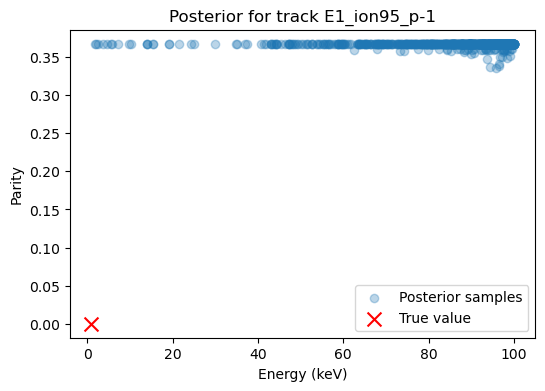

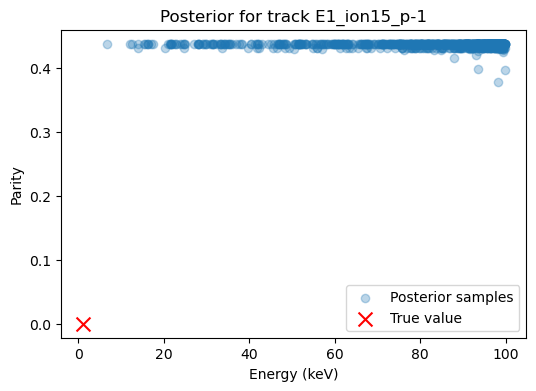

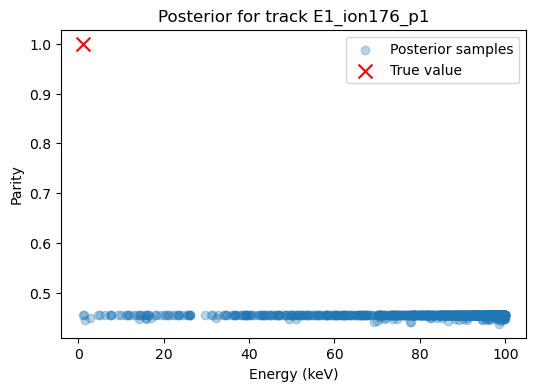

In [123]:
import matplotlib.pyplot as plt

for i, samples in enumerate(posterior_samples[:3]):  # first few examples
    e_true = x_test_df.iloc[i]["energy_keV"]
    p_true = 0 if x_test_df.iloc[i]["parity"] == -1 else 1

    plt.figure(figsize=(6,4))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, label="Posterior samples")
    plt.scatter([e_true], [p_true], color='red', label="True value", marker="x", s=100)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Parity")
    plt.title(f"Posterior for track {x_test_df.iloc[i]['track_id']}")
    plt.legend()
    plt.show()

In [124]:
import numpy as np

e_true_list, e_pred_list, e_err_list = [], [], []
p_true_list, p_pred_list, p_raw_list = [], [], []

for i, samples in enumerate(posterior_samples):
    e_true = x_test_df.iloc[i]["energy_keV"]
    p_true = 0 if x_test_df.iloc[i]["parity"] == -1 else 1

    e_pred_mean = samples[:, 0].mean().item()
    p_pred_mean = samples[:, 1].mean().item()
    p_pred = 1 if p_pred_mean >= 0.5 else 0

    e_err = abs(e_pred_mean - e_true) / e_true * 100

    # store metrics
    e_true_list.append(e_true)
    e_pred_list.append(e_pred_mean)
    e_err_list.append(e_err)
    p_true_list.append(p_true)
    p_pred_list.append(p_pred)
    p_raw_list.append(p_pred_mean)

In [125]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Parity classification accuracy
parity_acc = accuracy_score(p_true_list, p_pred_list)
cm = confusion_matrix(p_true_list, p_pred_list)

print(f"Parity accuracy: {parity_acc*100:.2f}%")
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Energy error
mean_err = np.mean(e_err_list)
median_err = np.median(e_err_list)
print(f"Mean energy % error: {mean_err:.2f}% | Median: {median_err:.2f}%")

Parity accuracy: 38.04%
Confusion matrix (rows=true, cols=pred):
 [[26 20]
 [37  9]]
Mean energy % error: 758.87% | Median: 88.62%


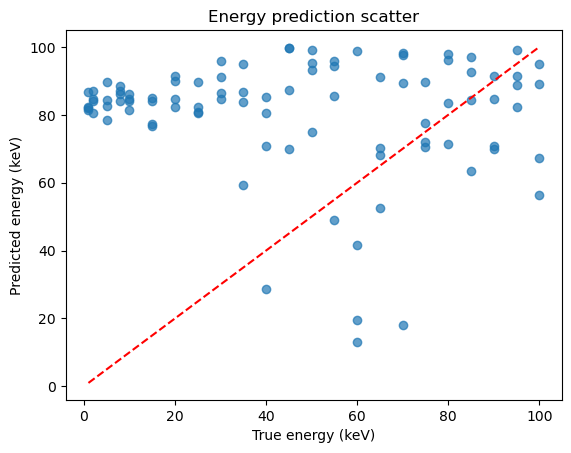

In [126]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(e_true_list, e_pred_list, alpha=0.7)
plt.plot([min(e_true_list), max(e_true_list)],
         [min(e_true_list), max(e_true_list)], 'r--')
plt.xlabel("True energy (keV)")
plt.ylabel("Predicted energy (keV)")
plt.title("Energy prediction scatter")
plt.show()

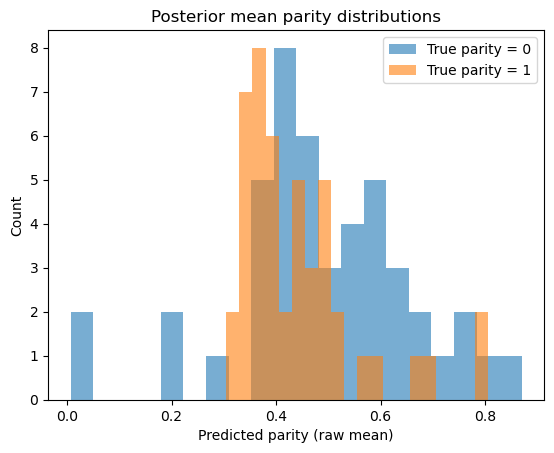

In [127]:
plt.figure()
plt.hist([p for p, t in zip(p_raw_list, p_true_list) if t==0],
         bins=20, alpha=0.6, label="True parity = 0")
plt.hist([p for p, t in zip(p_raw_list, p_true_list) if t==1],
         bins=20, alpha=0.6, label="True parity = 1")
plt.xlabel("Predicted parity (raw mean)")
plt.ylabel("Count")
plt.legend()
plt.title("Posterior mean parity distributions")
plt.show()

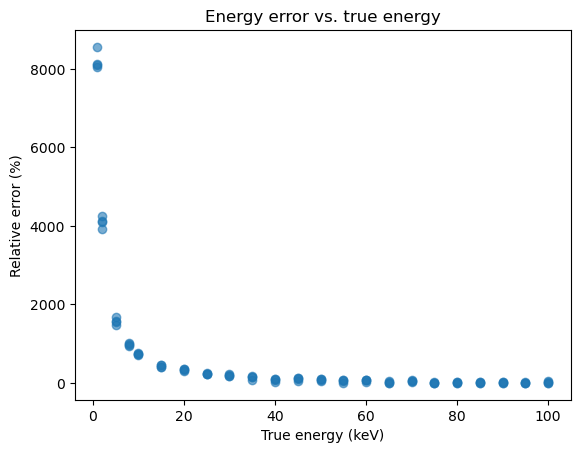

In [95]:
plt.figure()
plt.scatter(e_true_list, e_err_list, alpha=0.6)
plt.xlabel("True energy (keV)")
plt.ylabel("Relative error (%)")
plt.title("Energy error vs. true energy")
plt.show()